In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Check if adata is defined
if 'adata' not in locals() and 'adata' not in globals():
    # Filepath
    file_path = "/home/.../01_mouse_reprocessed.h5ad"

    # Read h5ad
    adata = sc.read_h5ad(file_path)
    print(f"Loaded AnnData object: {adata}")


Loaded AnnData object: AnnData object with n_obs × n_vars = 2004 × 34346
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'stage', 'timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'gene_ids', 'gene_symbol', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'


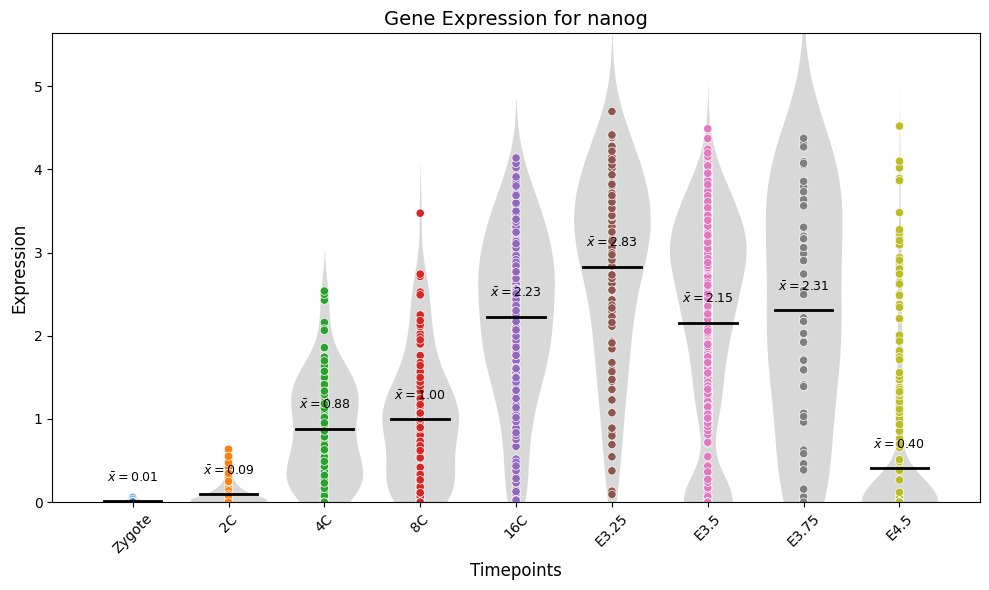

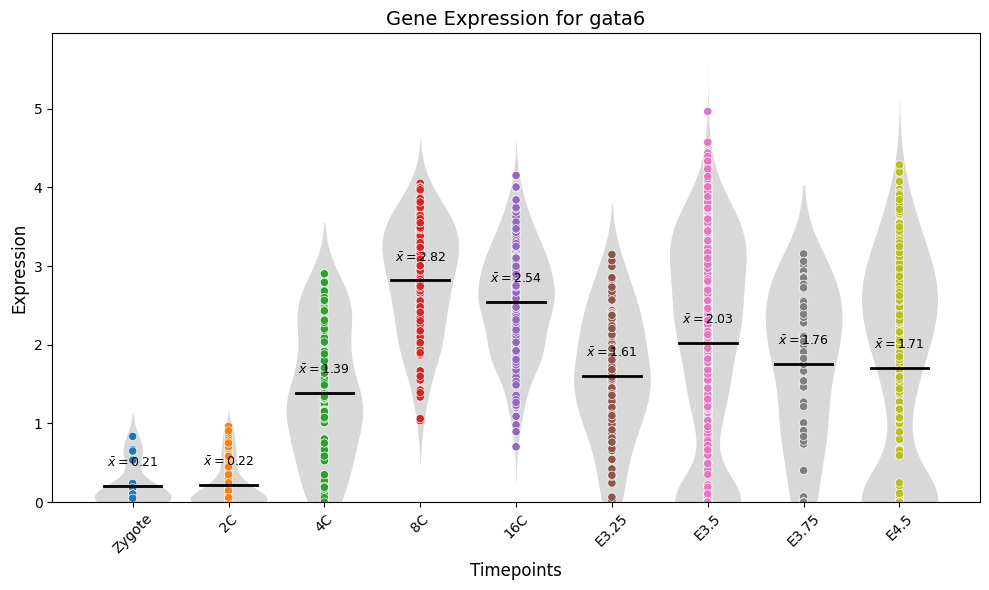

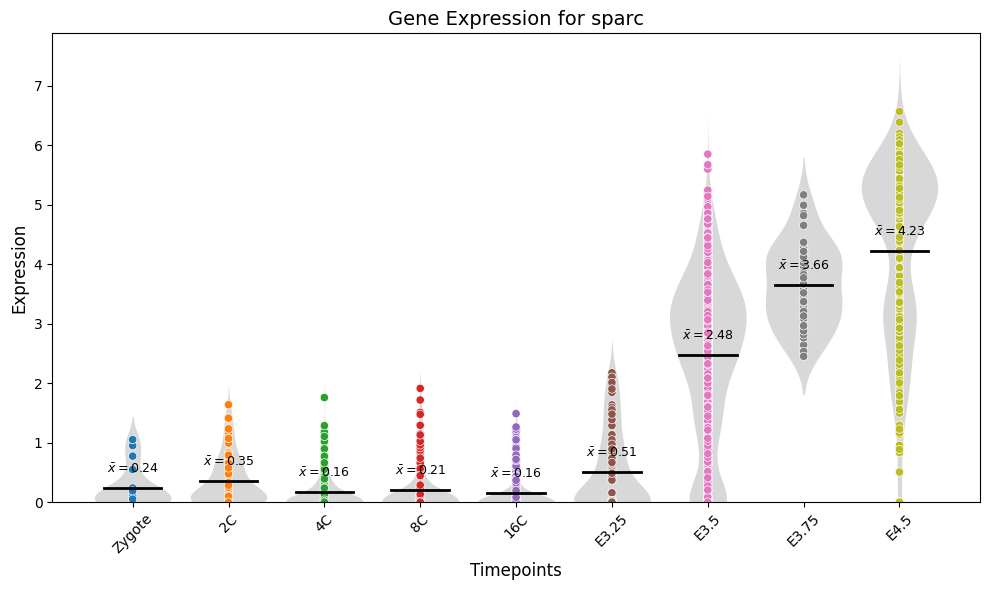

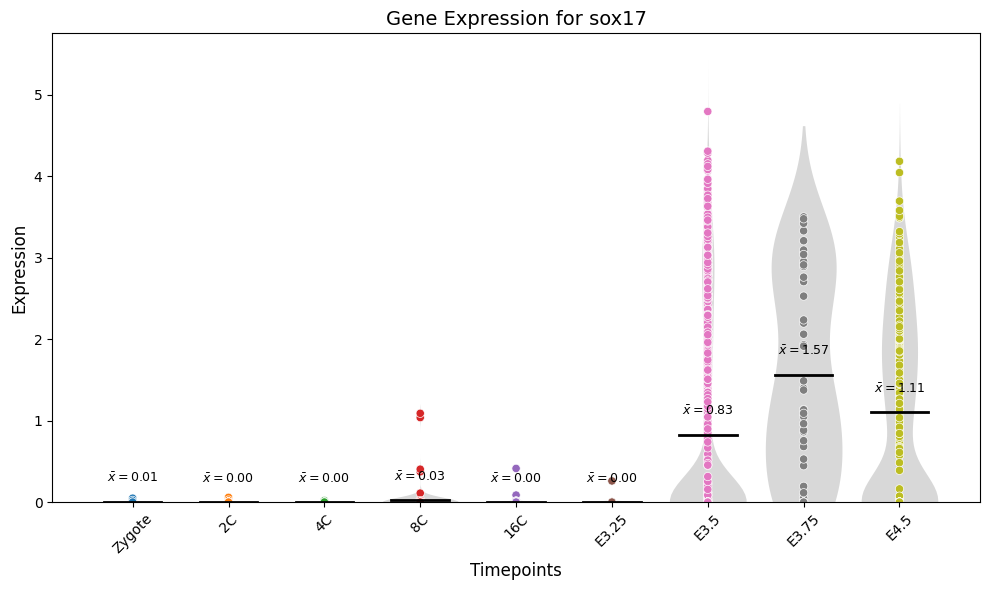

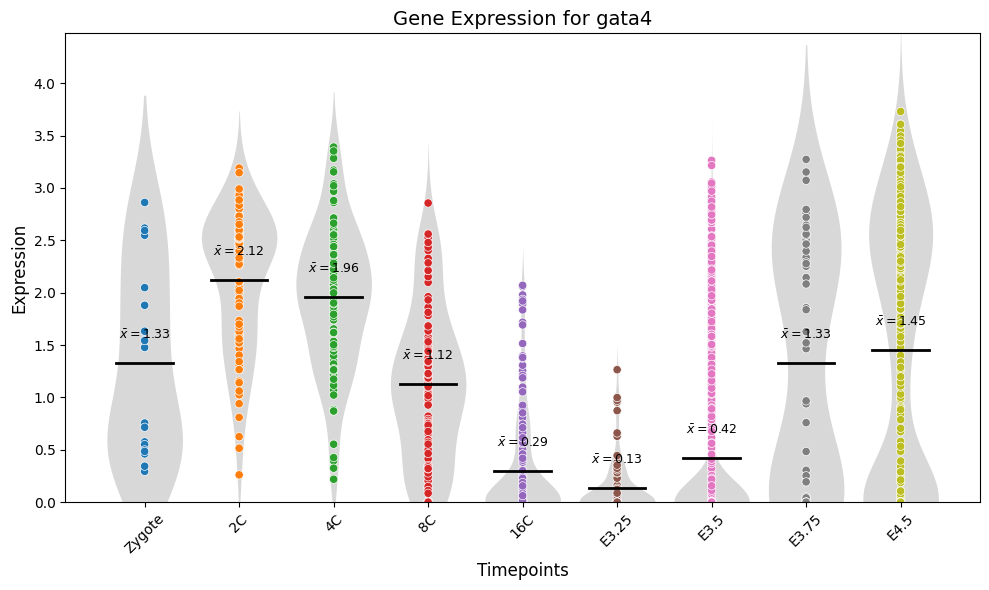

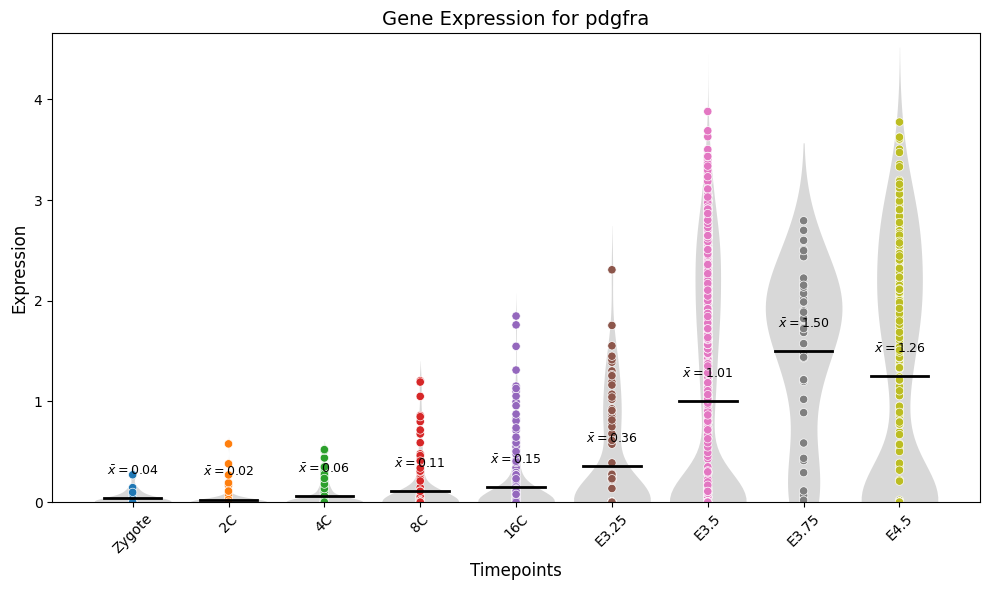

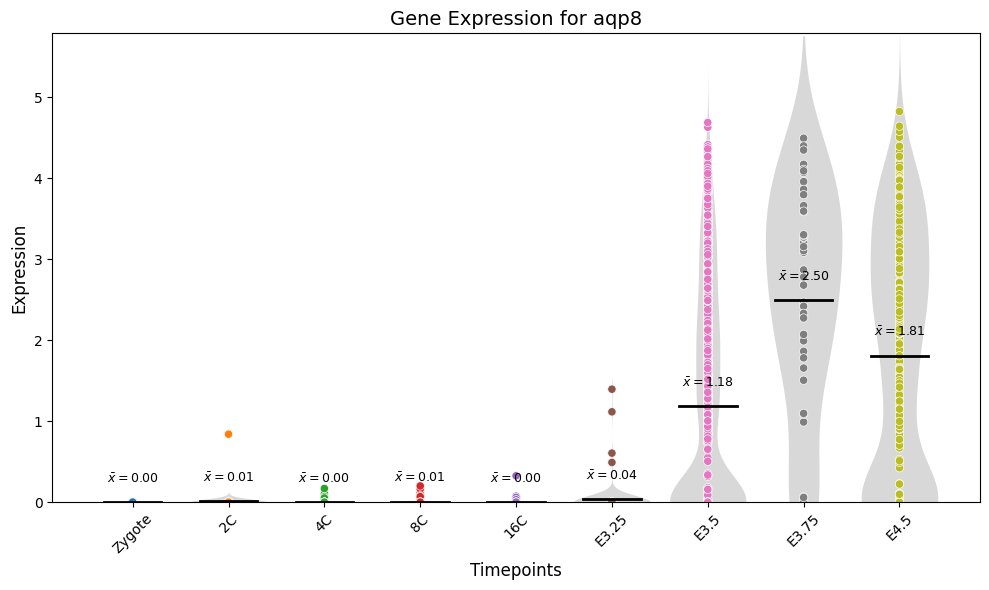

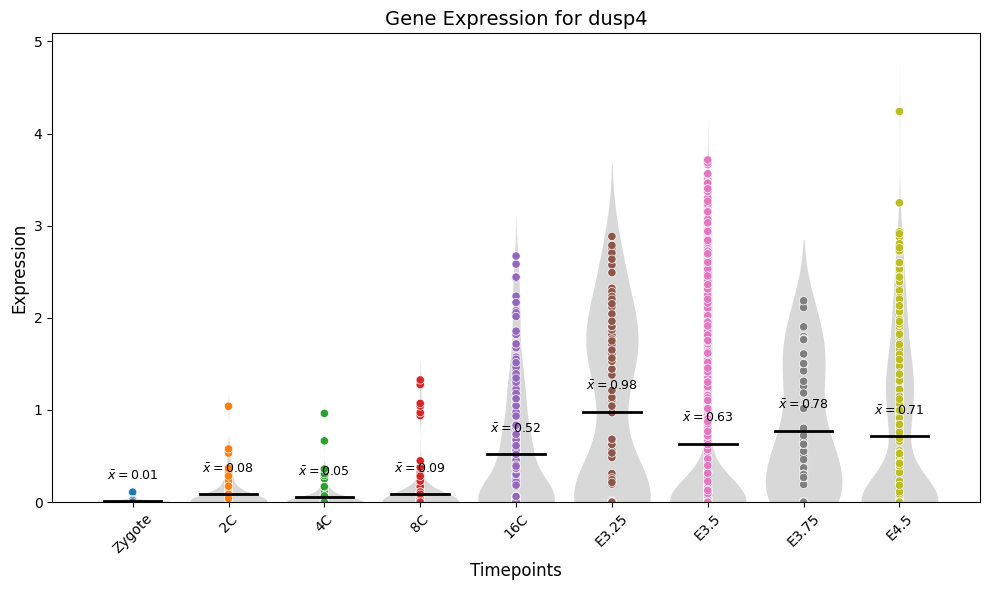

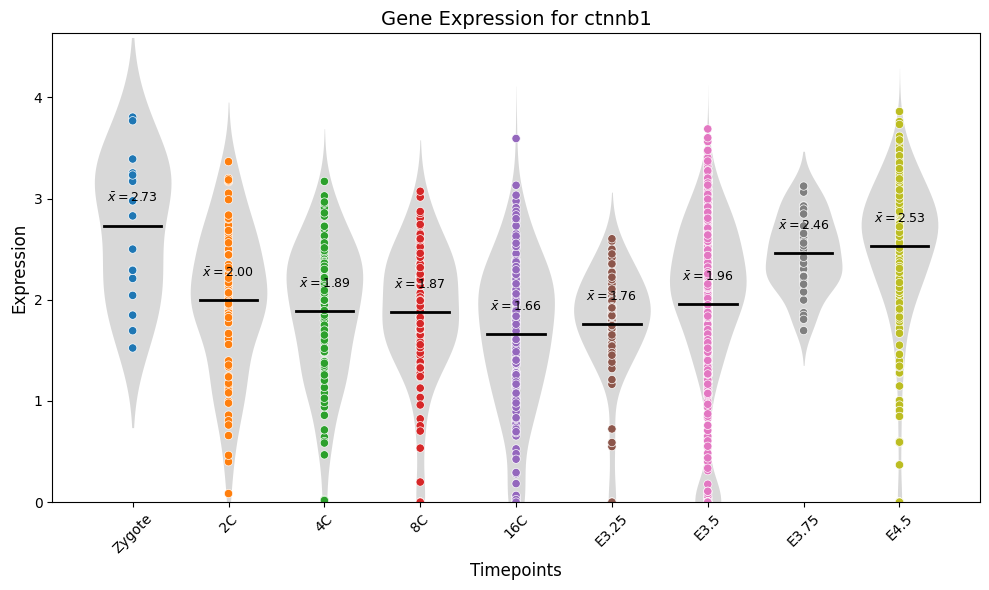

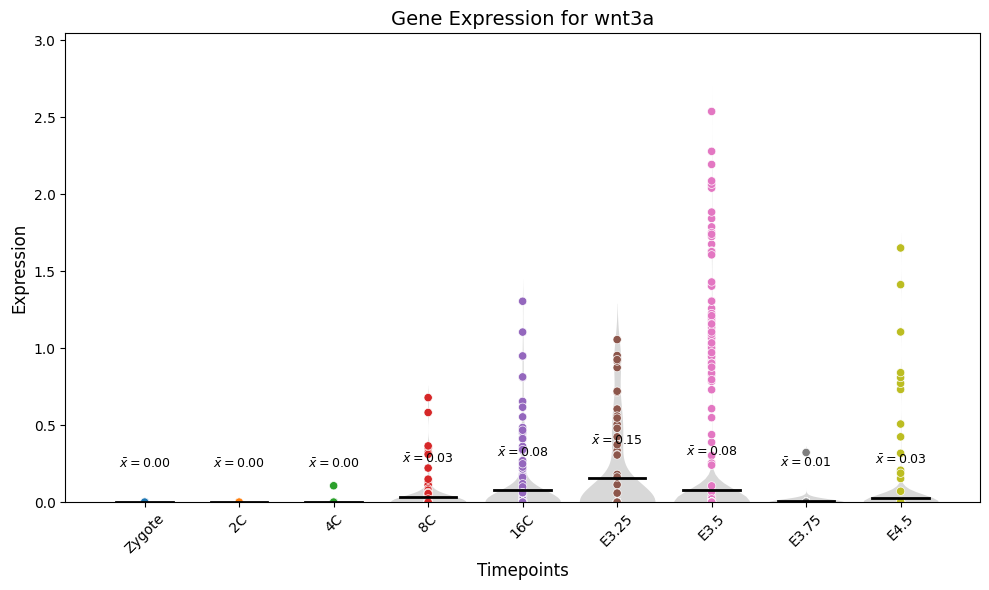

In [3]:
#VIOLIN PLOTS by TimePoints.
def plot_violin_by_timepoints(
    adata, 
    genes, 
    timepoint_order, 
    save_prefix="Gene", 
    figsize=(12, 6)
):
 
    # Ensure the "timepoint" column is categorized with the desired order
    adata.obs["timepoint"] = pd.Categorical(
        adata.obs["timepoint"],
        categories=timepoint_order,
        ordered=True
    )

    # Iterate through the list of genes to create individual plots
    for gene in genes:
        # Prepare data for plotting
        expression_data = pd.DataFrame({
            "timepoint": adata.obs["timepoint"],
            "expression": adata[:, gene].X.toarray().flatten()
        })

        # Compute mean expression for each timepoint
        mean_expr_by_timepoint = (
            expression_data.groupby("timepoint")["expression"].mean()
        )

        # Create the violin plot
        plt.figure(figsize=figsize)
        sns.violinplot(
            data=expression_data,
            x="timepoint",
            y="expression",
            density_norm='width',
            inner=None,  # No inner lines
            linewidth=0,
            color="gray",
            alpha=0.3  # Adjust transparency for better readability
        )
    
        # Plot scatter points
        sns.scatterplot(
            data=expression_data,
            x="timepoint",
            y="expression",
            hue="timepoint",
            palette="tab10",
              legend=False
        )

        # Add mean expression lines
        for idx, timepoint in enumerate(timepoint_order):
            if timepoint in mean_expr_by_timepoint:
                mean_expr = mean_expr_by_timepoint[timepoint]
                plt.plot(
                    [idx - 0.3, idx + 0.3],
                    [mean_expr, mean_expr],
                    color="black",
                    linewidth=2
                )  # Add mean line
                plt.text(
                    idx,
                    mean_expr + 0.2,
                    f"$\\bar{{x}}={mean_expr:.2f}$",
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    color="black"
                )  # Annotate mean value

        # Customize the plot
        plt.title(f"Gene Expression for {gene}", fontsize=14)
        plt.xlabel("Timepoints", fontsize=12)
        plt.ylabel("Expression", fontsize=12)
        plt.ylim(0, expression_data["expression"].max() * 1.2)  # Adjust y-axis to make space for annotations
        plt.xticks(rotation=45, fontsize=10)
        plt.tight_layout()

        # Save the plot
        os.makedirs("./figures", exist_ok=True)
        plt.savefig(f"./figures/{save_prefix}_{gene}_Timepoint.png", dpi=300)
        plt.show()

# Example Usage
# Define the custom order for timepoints
custom_order = ["Zygote", "2C", "4C", "8C", "16C", "E3.25", "E3.5", "E3.75", "E4.5"]

# List of genes to plot
genes_to_plot = ["nanog", "gata6", "sparc", "sox17", "gata4", "pdgfra", "aqp8", "dusp4", "ctnnb1", "wnt3a"]

# Call the function
plot_violin_by_timepoints(
    adata=adata, 
    genes=genes_to_plot, 
    timepoint_order=custom_order, 
    save_prefix="ViolinPlot", 
    figsize=(10, 6)
)


Filtered data shape: (175, 34346)


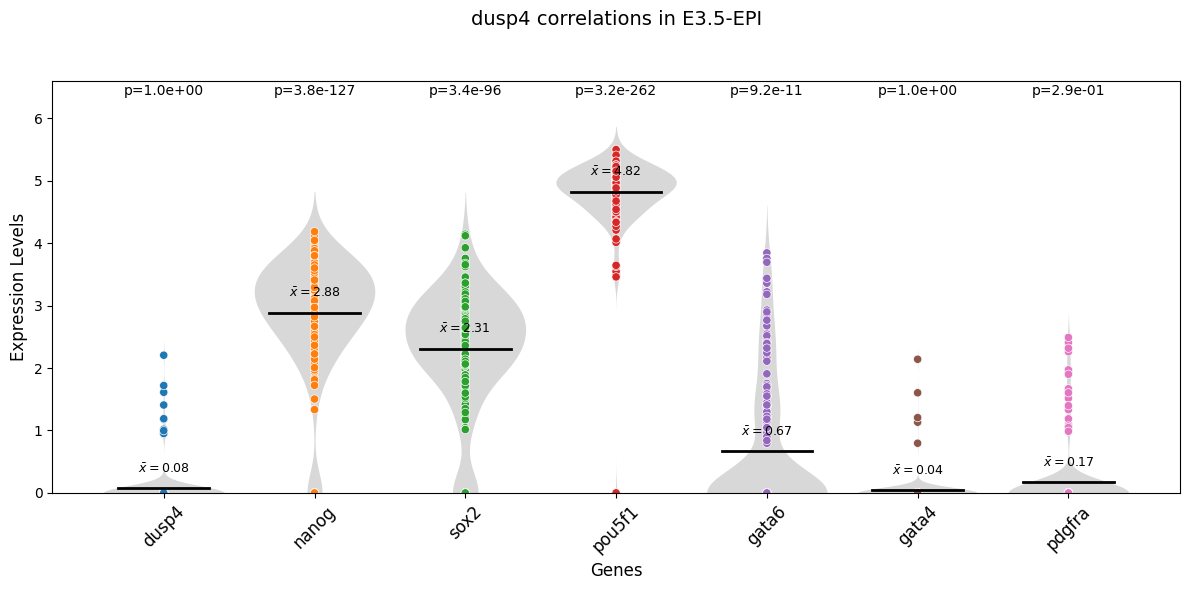

Filtered data shape: (254, 34346)


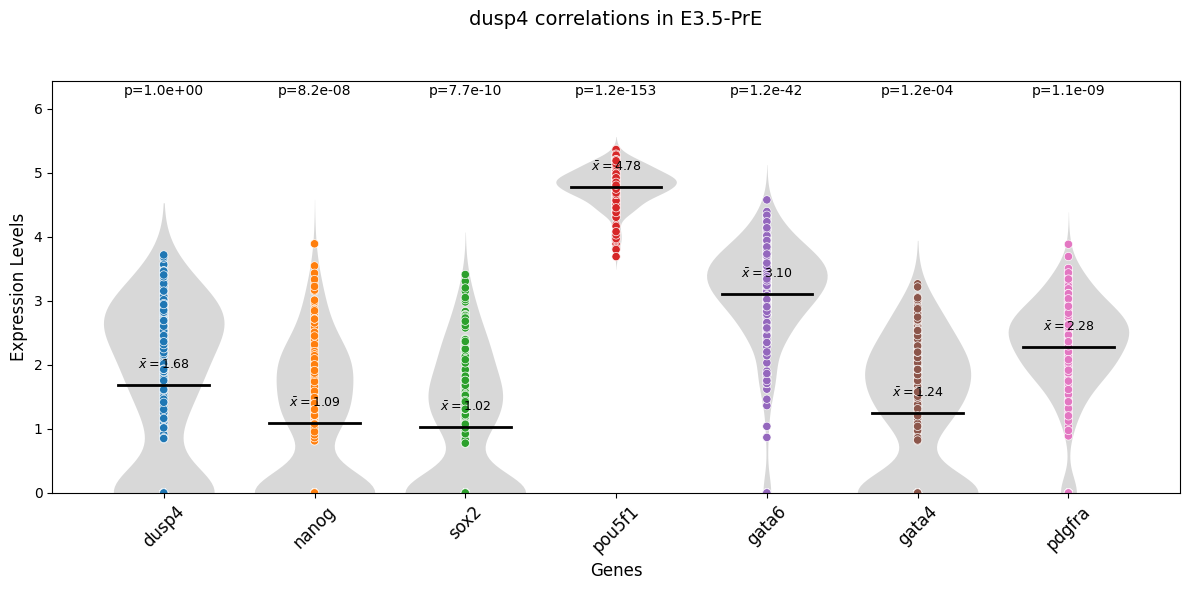

Filtered data shape: (459, 34346)


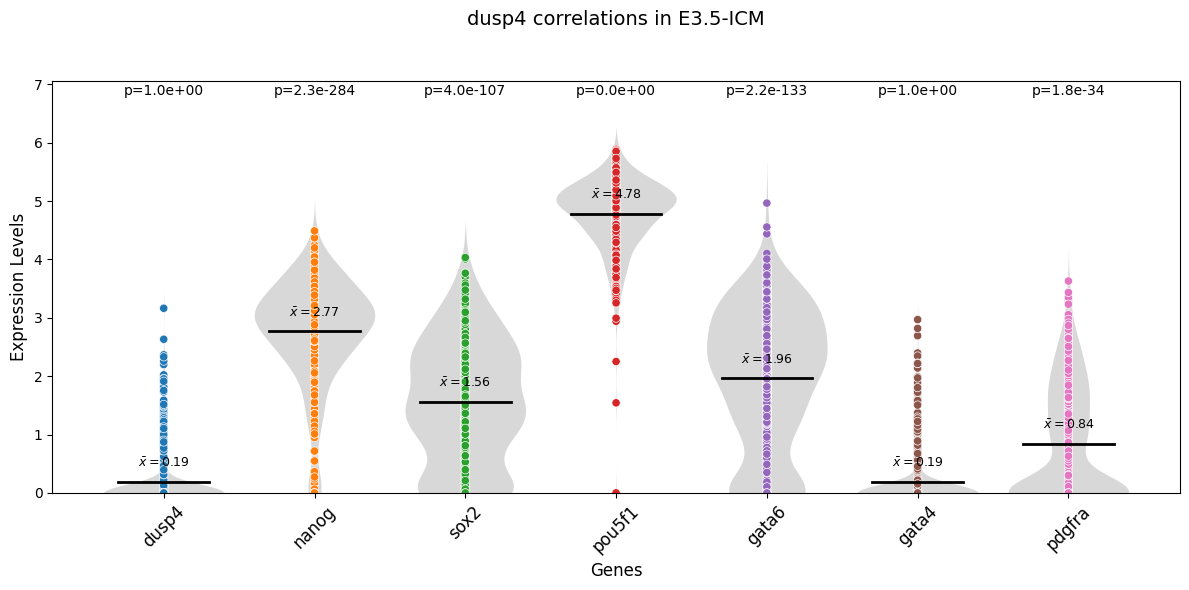

Filtered data shape: (175, 34346)


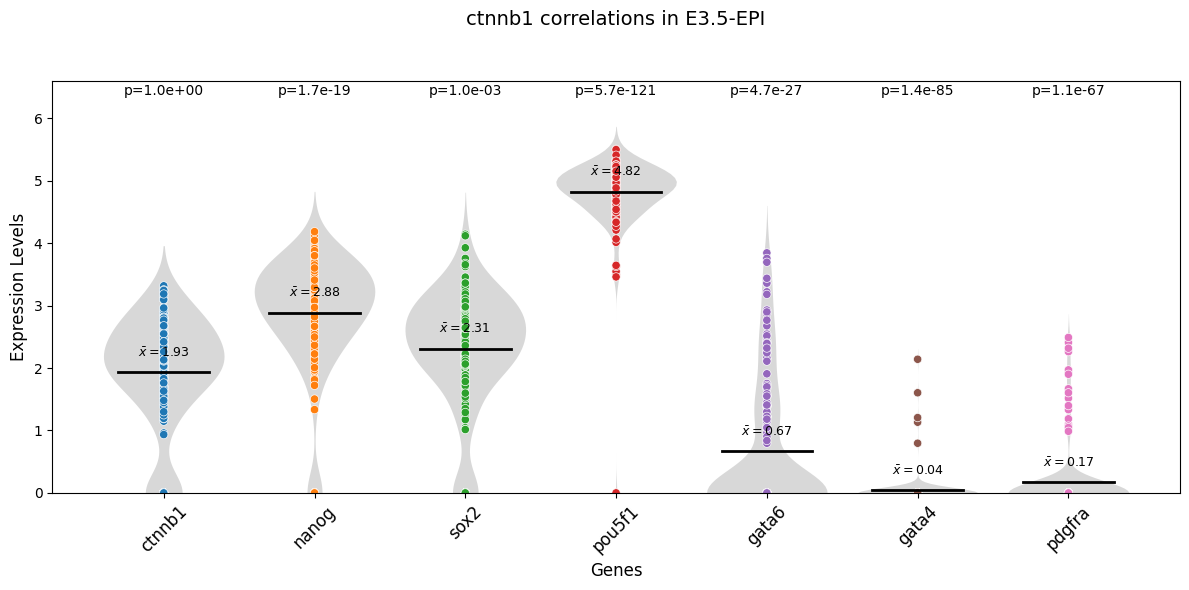

Filtered data shape: (254, 34346)


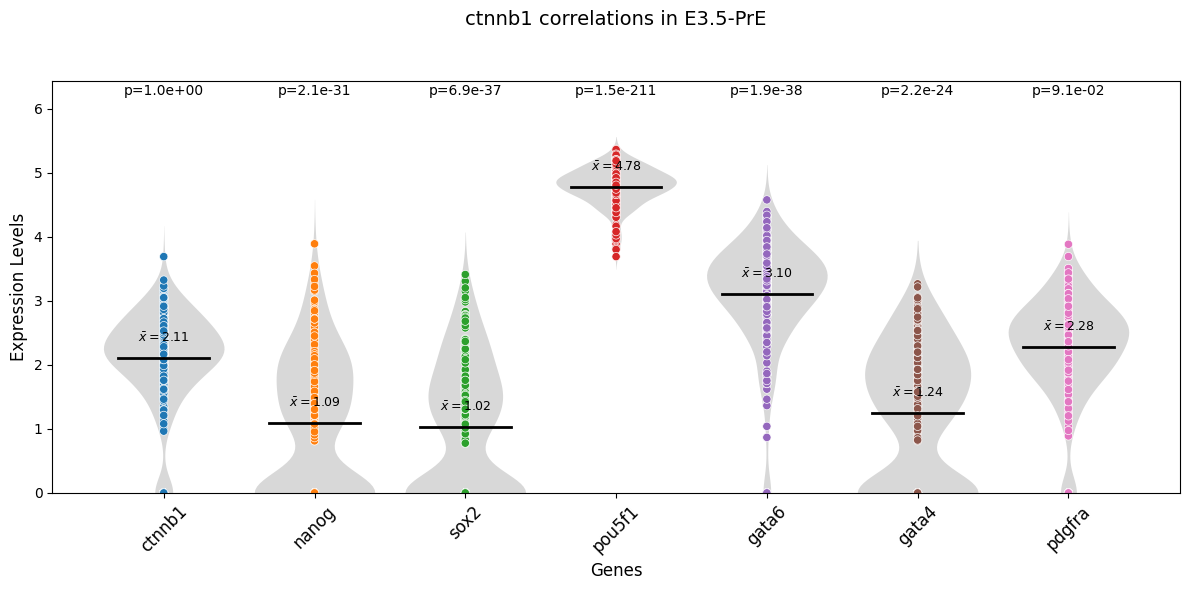

Filtered data shape: (459, 34346)


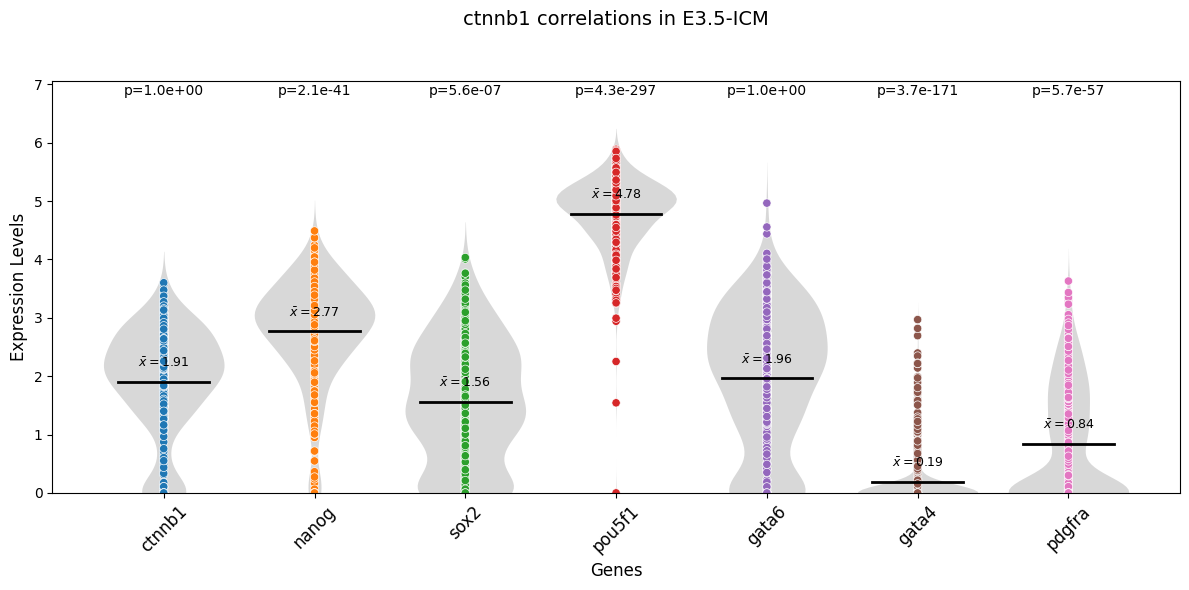

In [8]:
#SCATTER WITH VIOLIN PLOTS.
#t-test and bonferroni correction of gene expression comparisons amongst a target gene and others.

def plot_gene_expression_with_violin_and_means(adata, genes, target_gene, timepoint_filter=None, cell_type_filter=None, save_prefix="Gene"):

    
    # Ensure the target gene is the first in the list
    genes = [target_gene] + [gene for gene in genes if gene != target_gene]
    
    # Step 1: Filter the AnnData object by timepoint and/or cell type
    adata_filtered = adata
    if timepoint_filter:
        adata_filtered = adata_filtered[adata_filtered.obs["UnifiedTimePoint"] == timepoint_filter]
    if cell_type_filter:
        adata_filtered = adata_filtered[adata_filtered.obs["ct"] == cell_type_filter]

    # Ensure there are enough cells for analysis
    if adata_filtered.n_obs == 0:
        print("No cells match the given filters. Skipping.")
        return

    # Step 2: Extract expression data for the target gene and the provided genes
    expression_data = {}
    for gene in genes:
        gene_data = adata_filtered[:, gene].X.toarray().flatten()
        expression_data[gene] = gene_data

    # Step 3: Compute t-test p-values between each gene and the target gene
    raw_p_values = []
    for gene in genes:
        target_data = expression_data[target_gene]
        gene_data = expression_data[gene]

        # Check for variability in both datasets
        if np.all(target_data == target_data[0]) or np.all(gene_data == gene_data[0]):
            raw_p_values.append(np.nan)  # Cannot compute t-test
        else:
            _, pval = ttest_ind(target_data, gene_data)
            raw_p_values.append(pval)

    # Correct p-values using Bonferroni correction
    corrected_p_values = multipletests(raw_p_values, method="bonferroni")[1]

    # Step 4: Prepare data for the scatter plot
    df = pd.DataFrame(expression_data)
    df_melted = df.melt(var_name="Gene", value_name="Expression")

    # Map genes to their positions on the x-axis
    gene_positions = {gene: idx for idx, gene in enumerate(genes)}
    df_melted["X"] = df_melted["Gene"].map(gene_positions)

    # Step 5: Plot the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(
        data=df_melted,
        x="Gene",
        y="Expression",
        density_norm='width',
        inner=None,  # No inner lines
        alpha=0.3,  # High transparency
        color="gray",
        linewidth=0  # No edge
    )

    # Step 6: Plot the scatter plot
    sns.scatterplot(data=df_melted, x="X", y="Expression", hue="Gene", palette="tab10", legend=False)

    # Step 7: Add mean expression lines
    for idx, gene in enumerate(genes):
        mean_expr = df[gene].mean()
        plt.plot([idx - 0.3, idx + 0.3], [mean_expr, mean_expr], color="black", linewidth=2)  # Centered, thicker line
        plt.text(idx, mean_expr + 0.2, f"$\\bar{{x}}={mean_expr:.2f}$", ha="center", va="bottom", fontsize=9, color="black")

    # Step 8: Annotate with  corrected p-values
    for idx, gene in enumerate(genes):
        if idx < len(raw_p_values) and not np.isnan(raw_p_values[idx]):
            pval_text = f"p={corrected_p_values[idx]:.1e}"
        else:
            pval_text = "p=NaN"
        plt.text(idx, df_melted["Expression"].max() * 1.15, pval_text,
                 ha="center", va="bottom", fontsize=10, color="black")

    # Customize the plot
    plt.xticks(ticks=list(gene_positions.values()), labels=genes, rotation=45, fontsize=12)
    plt.title(f"{target_gene} correlations in {cell_type_filter}", fontsize=14, pad=40)  # Add spacing
    plt.xlabel("Genes", fontsize=12)
    plt.ylabel("Expression Levels", fontsize=12)
    plt.ylim(0, df_melted["Expression"].max() * 1.2)  # Adjust y-axis to make space for annotations
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"./figures/{cell_type_filter}_{target_gene}_{save_prefix}.png", dpi=300)
    plt.show()


# Ensure "UnifiedTimePoint" is defined
adata.obs["UnifiedTimePoint"] = adata.obs["timepoint"].str.split(":").str[0]

# Call the function
plot_gene_expression_with_violin_and_means(
    adata=adata, 
    genes=["nanog", "sox2", "pou5f1", "gata6", "gata4", "pdgfra"], 
    target_gene="dusp4", 
    timepoint_filter="E3.5", 
    cell_type_filter="E3.5-EPI", 
    save_prefix="Scatter_with_Violin_EPI_"
)

# Call the function
plot_gene_expression_with_violin_and_means(
    adata=adata, 
    genes=["nanog", "sox2", "pou5f1", "gata6", "gata4", "pdgfra"], 
    target_gene="dusp4", 
    timepoint_filter="E3.5", 
    cell_type_filter="E3.5-PrE", 
    save_prefix="Scatter_with_Violin_PRE_"
)

# Call the function
plot_gene_expression_with_violin_and_means(
    adata=adata, 
    genes=["nanog", "sox2", "pou5f1", "gata6", "gata4", "pdgfra"], 
    target_gene="dusp4", 
    timepoint_filter="E3.5", 
    cell_type_filter="E3.5-ICM", 
    save_prefix="Scatter_with_Violin_ICM_"
)

# Call the function
plot_gene_expression_with_violin_and_means(
    adata=adata, 
    genes=["nanog", "sox2", "pou5f1", "gata6", "gata4", "pdgfra"], 
    target_gene="ctnnb1", 
    timepoint_filter="E3.5", 
    cell_type_filter="E3.5-EPI", 
    save_prefix="Scatter_with_Violin_EPI_"
)

# Call the function
plot_gene_expression_with_violin_and_means(
    adata=adata, 
    genes=["nanog", "sox2", "pou5f1", "gata6", "gata4", "pdgfra"], 
    target_gene="ctnnb1", 
    timepoint_filter="E3.5", 
    cell_type_filter="E3.5-PrE", 
    save_prefix="Scatter_with_Violin_PRE_"
)

# Call the function
plot_gene_expression_with_violin_and_means(
    adata=adata, 
    genes=["nanog", "sox2", "pou5f1", "gata6", "gata4", "pdgfra"], 
    target_gene="ctnnb1", 
    timepoint_filter="E3.5", 
    cell_type_filter="E3.5-ICM", 
    save_prefix="Scatter_with_Violin_ICM_"
)

Filtered data shape: (87, 34346)
Top genes: ['gm12003', 'ctnnb1', 'snrnp27', 'eif1', '1810009a15rik', 'scyl1', 'selenok', 'mrpl40', 'hsf2bp', 'sf3a2', 'hsph1', 'mob1a', 'anks3', 'fus', 'mrpl47', 'rab29', 'sdhaf4', 'cxxc1', 'nsmce1', 'cbx7']


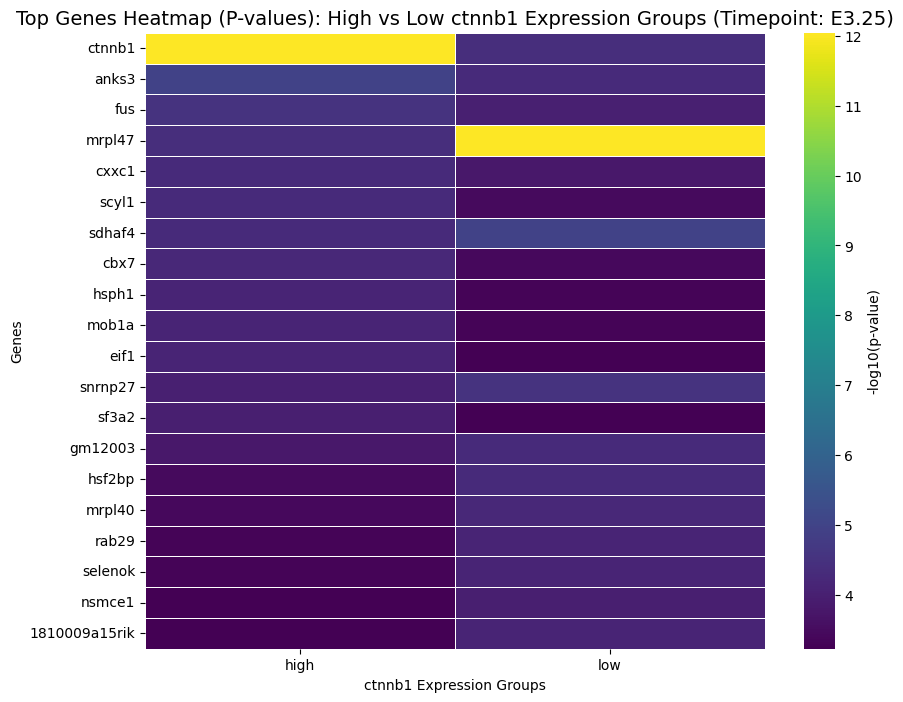

Filtered data shape: (995, 34346)
Top genes: ['psma7', 'gm6789', 'ptbp1', 'ctnnb1', 'ndufb8', 'nhp2', 'gm43247', 'cd63', 'map1lc3b', 'psmb6', 'dppa3', 'vcp', 'gm11949', 'lamtor2', 'ap1g1', 'pnpt1', 'hnrnpu', 'gm14016', 'eef1a1', 'gm49909']


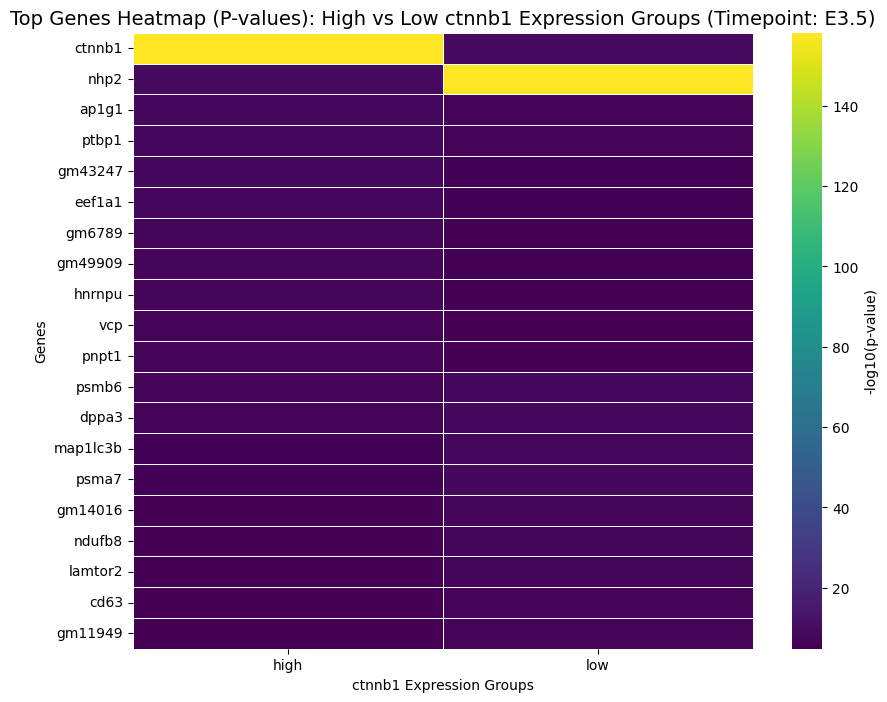

Filtered data shape: (343, 34346)
Top genes: ['gm19810', 'ctnnb1', 'cox6b1', 'gm5449', 'slc9a3r1', 'ac160336.1', 'gldc', 'gm4987', 'gm6252', 'hnrnpab', 'hnrnpf', 'etf1', 'scd2', 'hnrnpul2', 'gm16412', 'pabpc4', 'gm15710', 'gm11401', 'gm38247', 'gm14044']


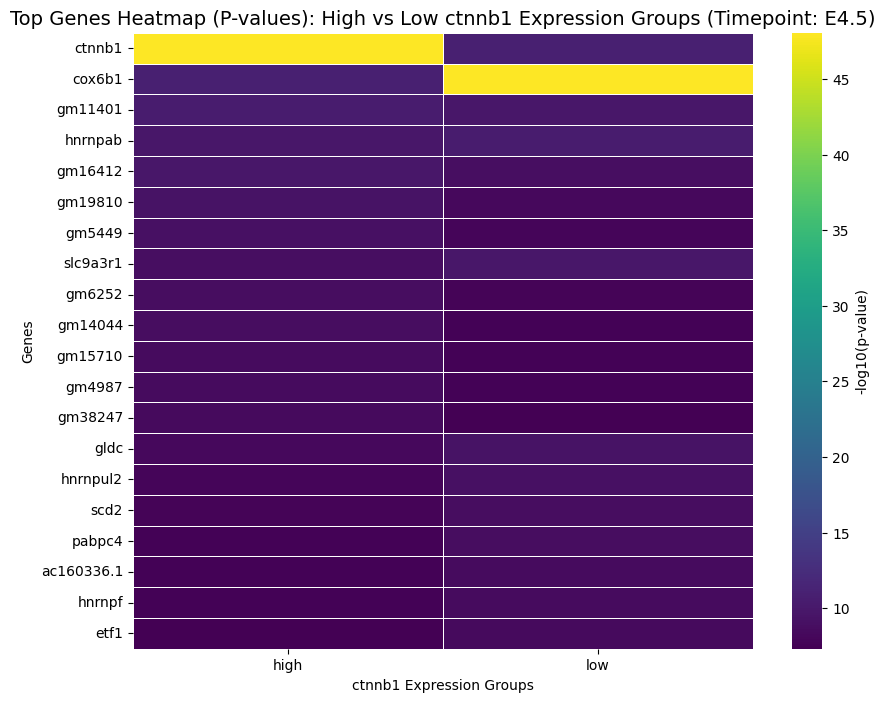

Filtered data shape: (40, 34346)
Top genes: ['wbp1l', 'mcrs1', 'timm23', 'smim26', 'gzf1', 'ctnnb1', 'kansl2', 'gm6180', 'gak', 'polr2j', 'gm23968', 'hsph1', 'cdc37l1', 'gm12999', 'mrpl47', 'sphk2', 'prpf38a', 'rab7', 'gm12005', 'zfp839']


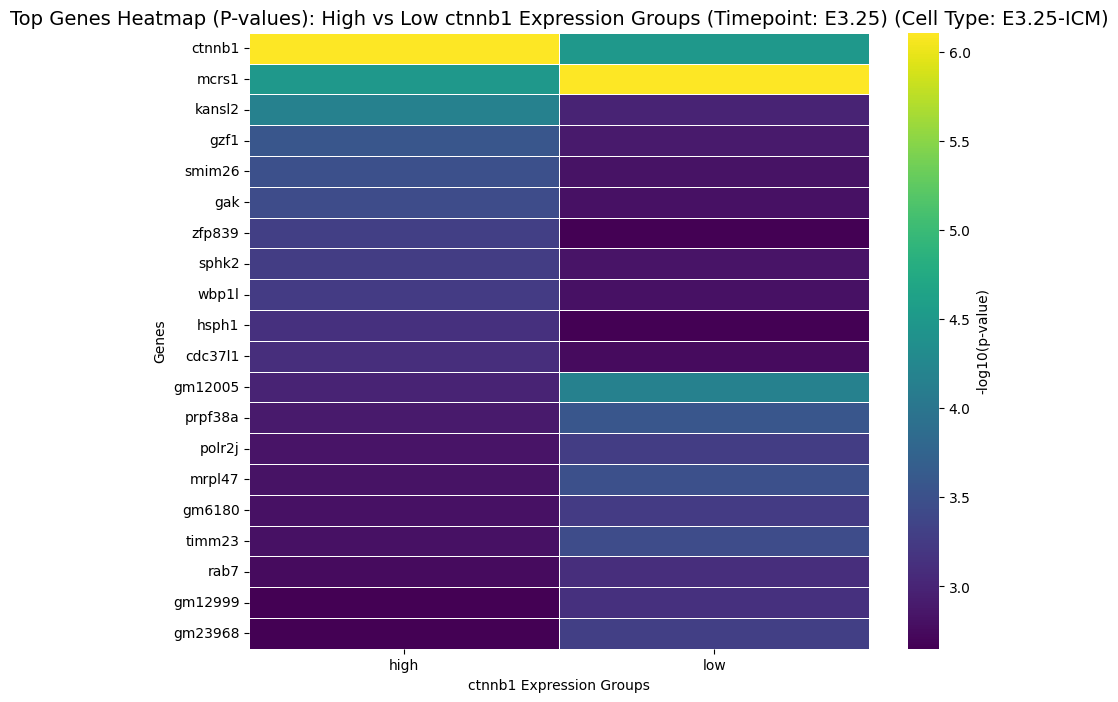

Filtered data shape: (459, 34346)
Top genes: ['gm6789', 'aacs', 'ctnnb1', 'ndufb8', 'actg1', 'calm1', 'nhp2', 'gm43247', 'h2az2', 'aa465934', 'timm13', 'mapk1', 'map1lc3b', 'nme1', 'lamtor2', 'pomp', 'ranbp1', 'eef1a1', 'msh6', 'nanog']


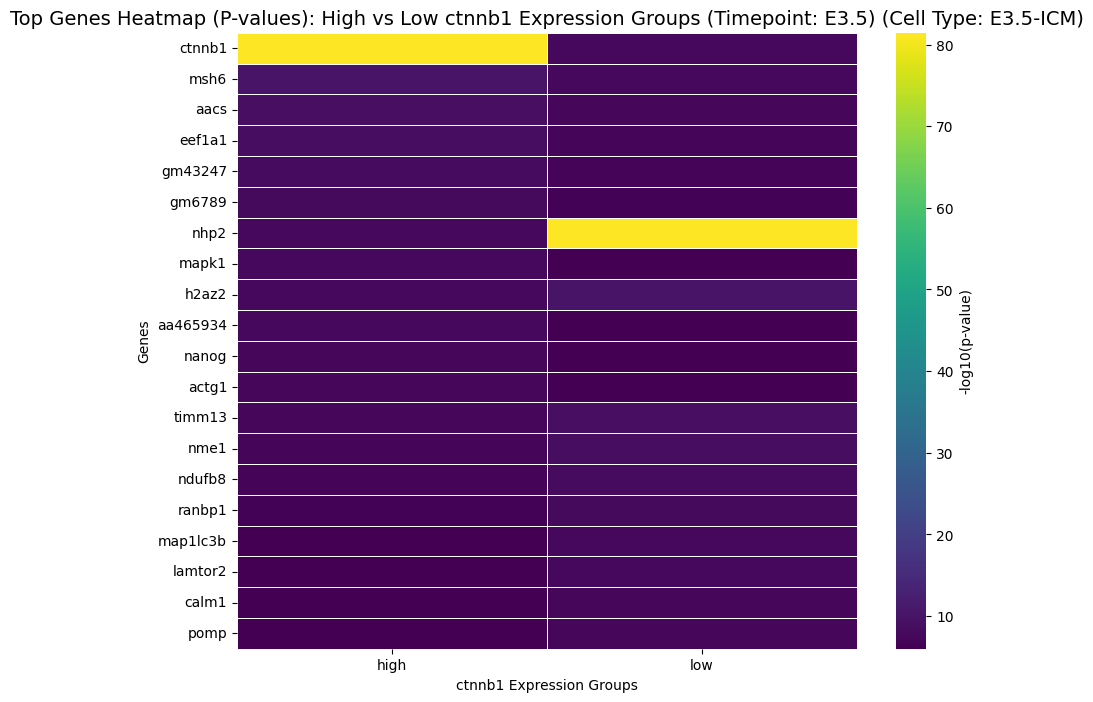

Filtered data shape: (175, 34346)
Top genes: ['rnf44', 'ctnnb1', 'proser3', 'ski', 'sumo3', 'armt1', 'sncb', 'scamp2', 'ddx52', 'eef2k', 'pacsin1', 'hgh1', '2610507b11rik', 'ap1g1', 'baz1b', 'exosc8', 'pecam1', 'gm14305', 'spsb2', 'zfp646']


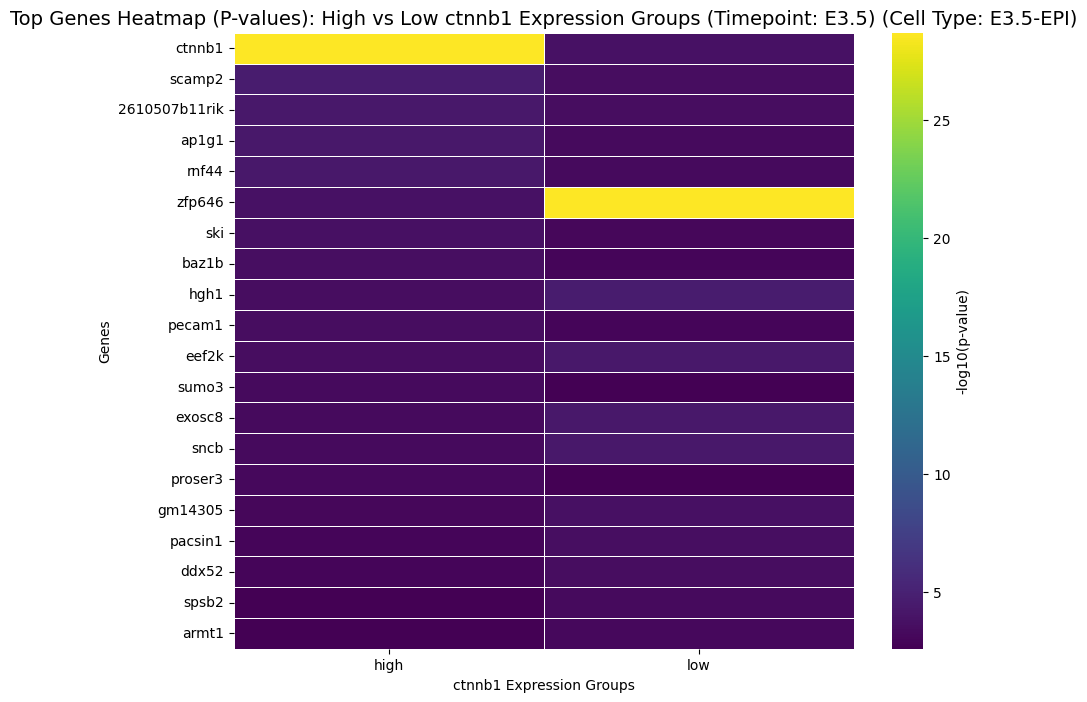

Filtered data shape: (254, 34346)
Top genes: ['amotl2', 'lama1', 'ctnnb1', 'rnaseh2b', 'rnf130', 'atg4b', 'syce2', 'ggcx', 'nhp2', 'efna2', 'fam160b2', 'b4galt6', 'polr1d', 'gm38009', 'tfeb', 'tmem30b', 'ddx20', 'xpo6', 'crebzf', 'cdk5']


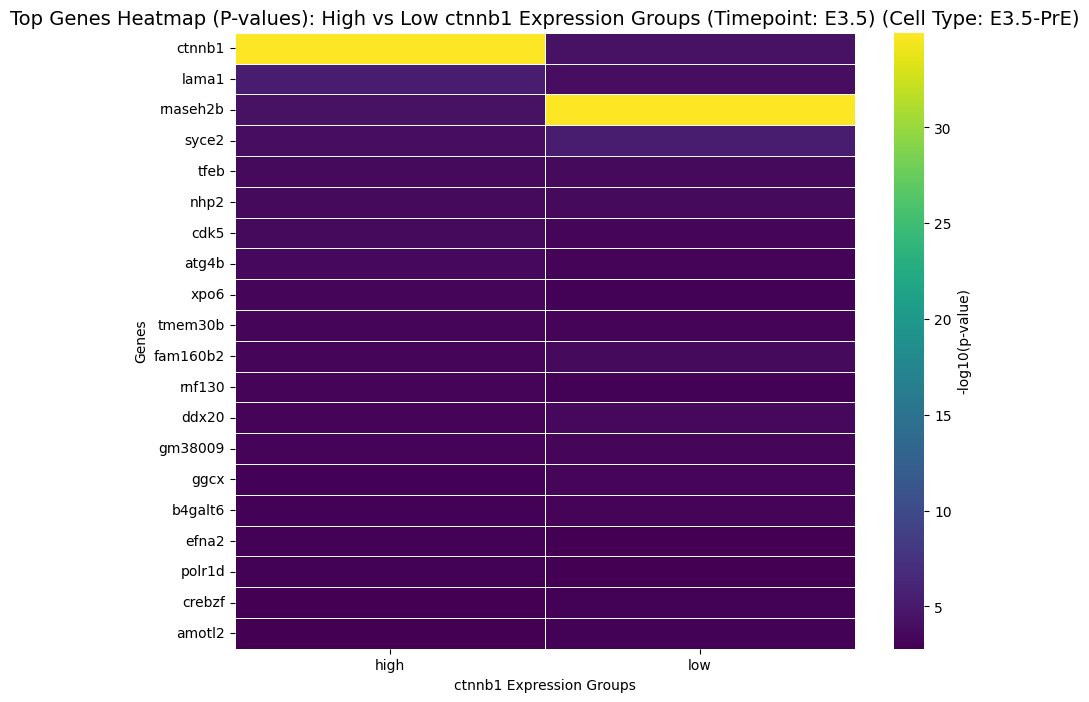

Filtered data shape: (108, 34346)
Top genes: ['ctnnb1', 'nid2', 'gm6392', 'fgd1', 'hnrnpab', 'gm2367', 'gm15772', 'gm8172', 'mif', 'gm15710', 'tuba1b', 'sms', 'ftl1', 'gm8606', 'gm11401', 'gm5297', 'pbdc1', 'pan3', 'cd9', 'apip']


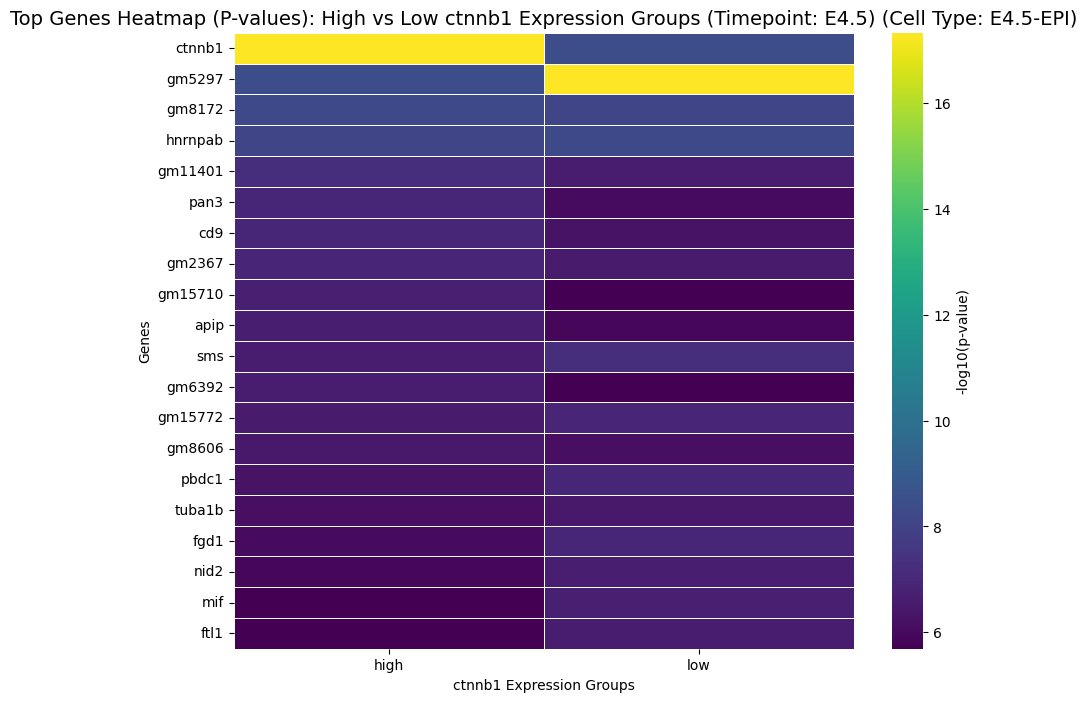

Filtered data shape: (207, 34346)
Top genes: ['ctnnb1', 'ppp1r15b', 'gm13341', 'slc9a3r1', 'taok1', 'lrrc58', 'gm44227', 'gldc', 'dppa5a', 'bcor', 'slc12a9', 'mcee', 'hnrnpul2', 'etf1', 'gm10146', 'gm14859', 'cox4i1', 'magoh', 'atp5c1', 'atp6v0e']


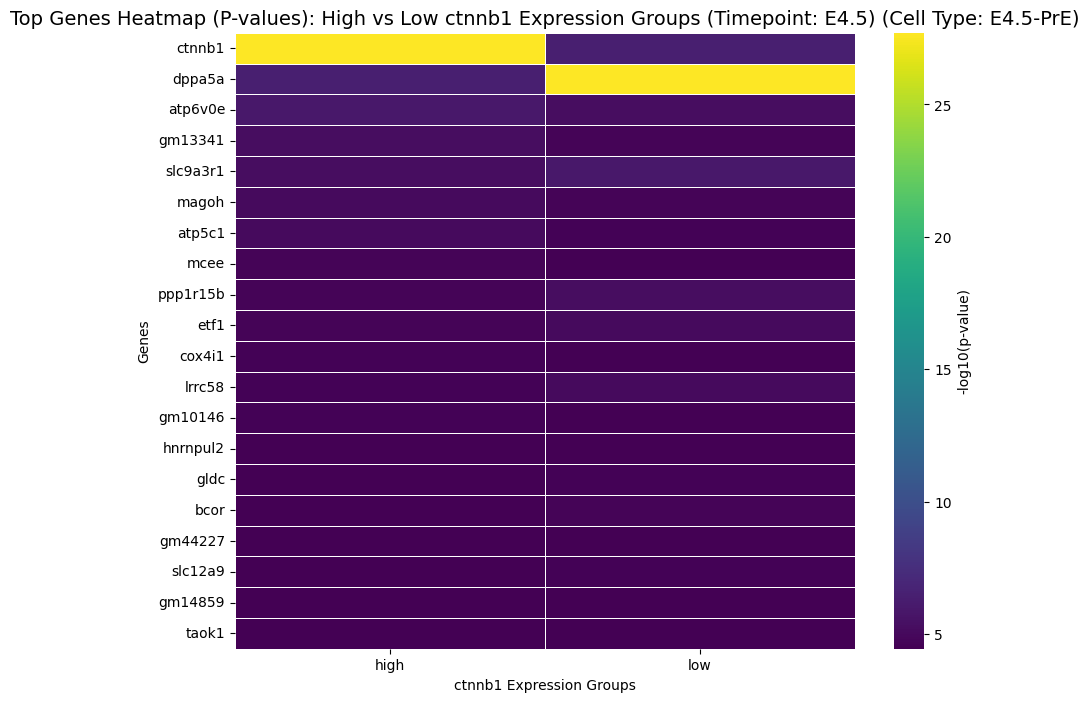

Filtered data shape: (87, 34346)
Top genes: ['dusp4', 'dab2', 'ssbp4', 'rnf130', 'krt8', 'cdx2', 'upp1', 'lrp2', 'tdgf1', 'krt18', 'psmb9', 'fabp3', 'klf2', 'gm49089', 'spic', 'tdgf1-ps1', 'ptges', 'pecam1', 'id2', 'ap2a2']


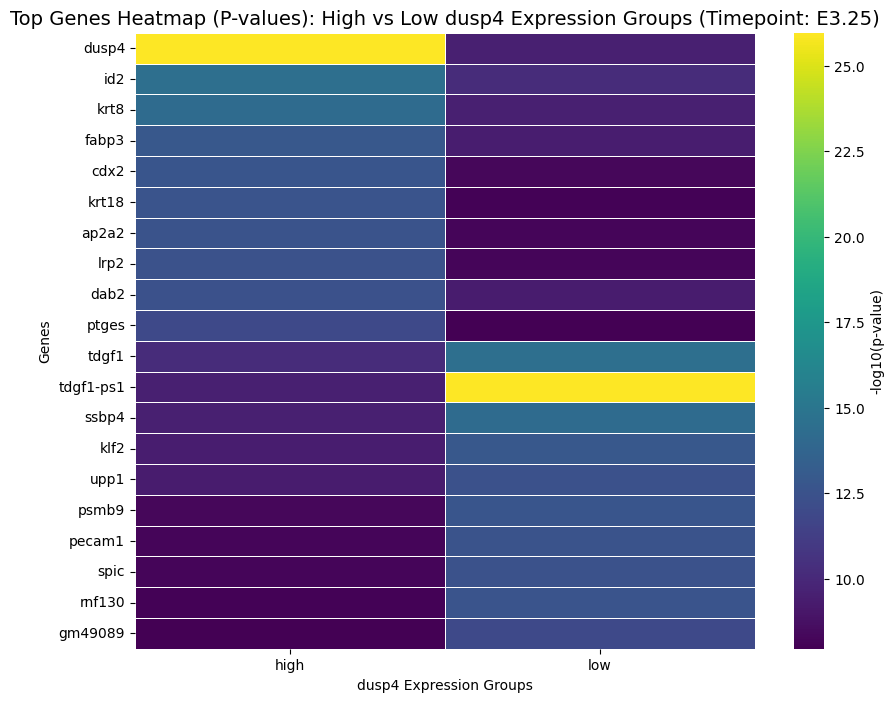

Filtered data shape: (995, 34346)
Top genes: ['dusp4', 'gm29770', 'trim43a', 'klf5', 'fgf4', 'dnmt3l', 'b4galt6', 'pdpn', 'cpn1', 'sox17', 'foxq1', 'dnmt3b', 'prdm14', 'apela', 'fgfr2', 'klf2', 'nanog', 'spic', 'gm13147', 'sdc4']


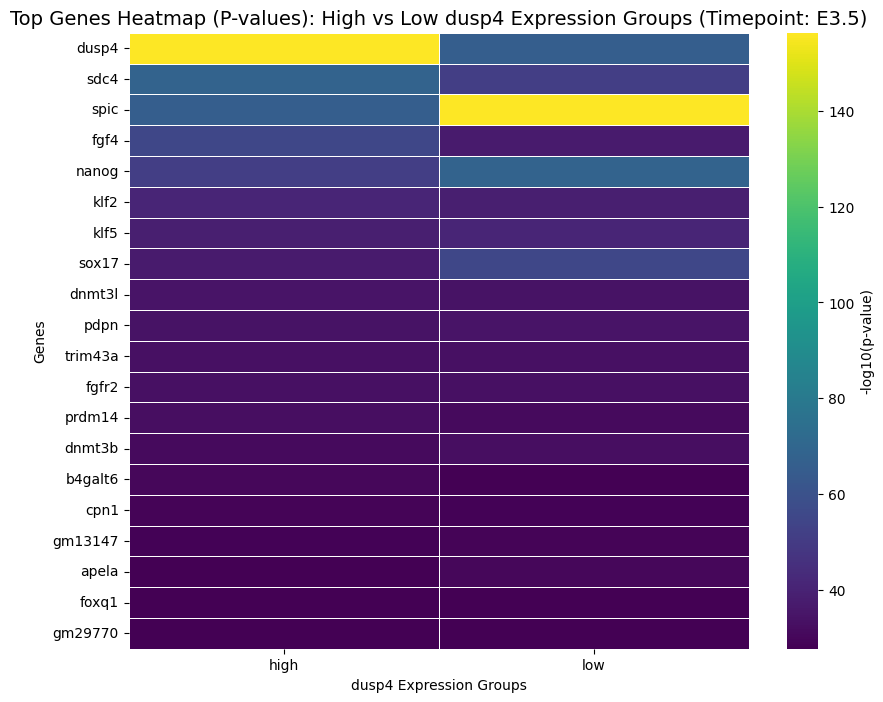

Filtered data shape: (343, 34346)
Top genes: ['dusp4', 'gm10243', 'gm28439', 'pfdn2', 'ubxn1', 'nmt1', 'utf1', 'gm4294', 'abcf1', 'gm13192', 'gm17802', 'gm8696', 'dppa4', 'eif3f', 'gm48690', 'gm14859', 'gm2830', 'gm14438', 'l1td1', 'eif1ax']


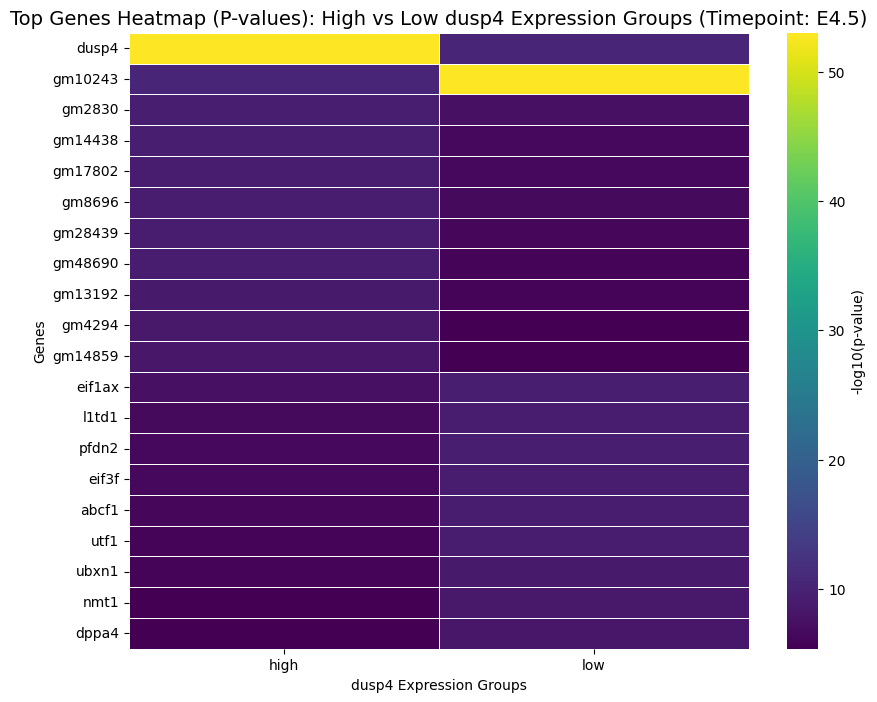

Filtered data shape: (40, 34346)
Top genes: ['ttll5', 'acpp', 'sult4a1', 'bin2', 'rnf166', 'snhg20', 'fcgrt', 'mterf2', 'crcp', 'upf2', 'nrbp1', 'slc28a3', 'cavin1', '1300002e11rik', 'rbbp8', 'gm17807', 'suv39h1', 'ogdhl', 'wdr70', 'ip6k2']


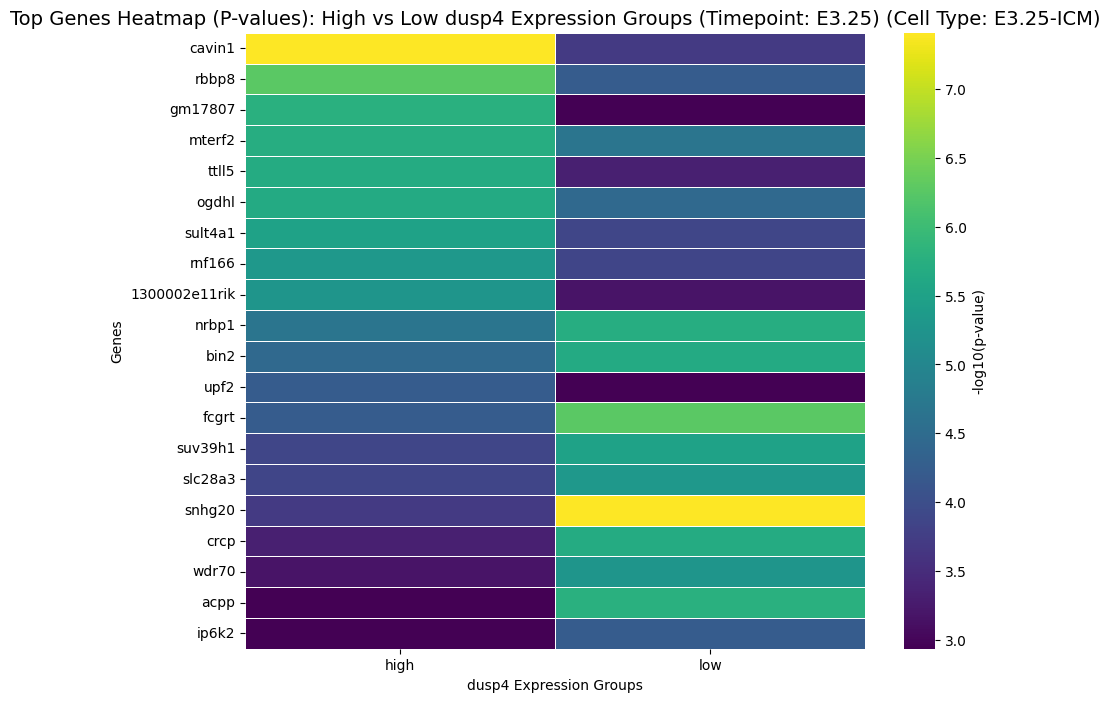

Filtered data shape: (459, 34346)
Top genes: ['gm45850', 'dusp4', 'tspan2os', 'gm12411', 'eri3', 'gm13532', 'atp5d', 'ndufa2', 'pfdn5', 'b4galt6', 'wbp11', 'fam168a', 'gm6883', 'gm13772', 'nat8f1', 'gpx4-ps1', 'nacc1', 'gm30155', 'cnpy2', 'gm2099']


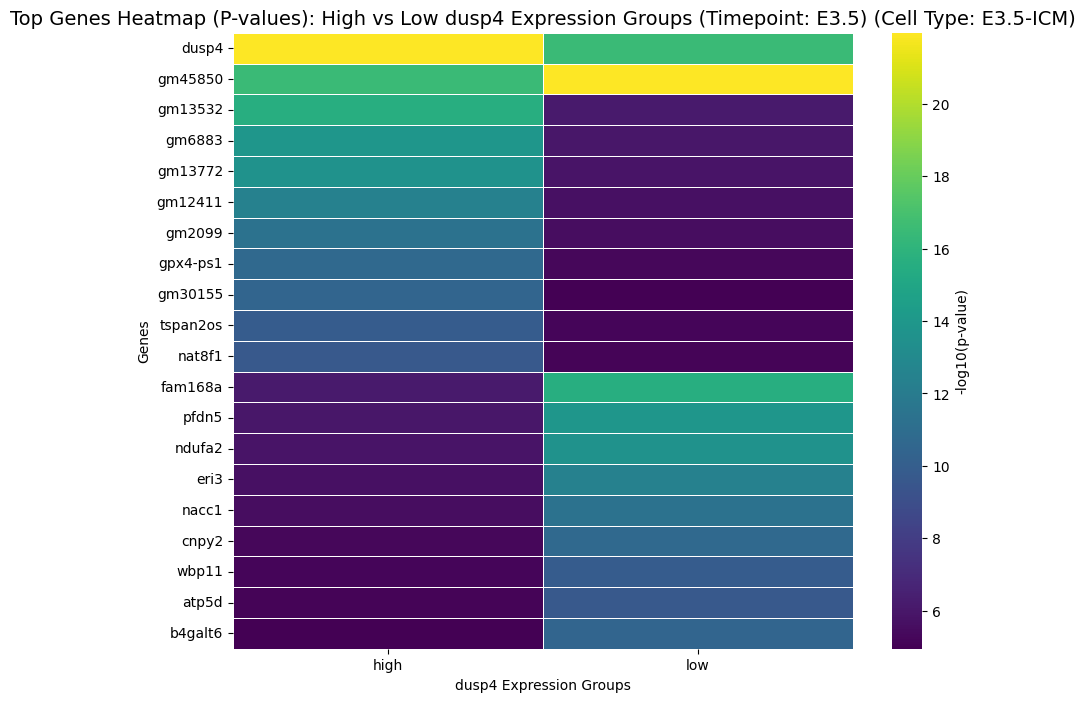

Filtered data shape: (175, 34346)
Top genes: ['aaas', 'dusp4', 'shq1', 'crlf3', 'nsd1', 'zyg11b', 'foxn2', 'parg', 'emsy', 'cebpz', 'nup93', 'lrrc47', 'mbip', 'acot8', 'tead2', 'mtg1', 'krcc1', 'nup214', '1110012l19rik', 'dgcr2']


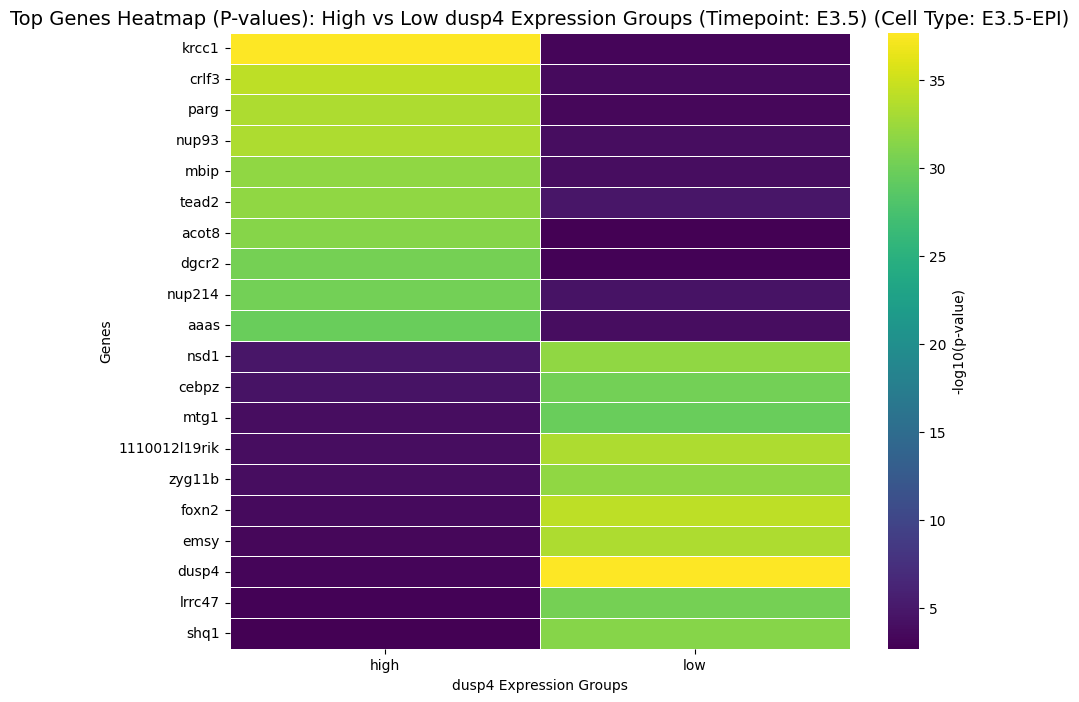

Filtered data shape: (254, 34346)
Top genes: ['dusp4', 'pgam2', 'lama1', 'trim43a', 'sfn', 'cldn4', 'tfpi', 'gata4', 'flrt3', 'pdpn', 'psap', 'foxq1', 'rab6a', 'glipr2', 'bcl2l14', 'tmem41b', 'dkk1', 'gm48847', 'spic', 'nanog']


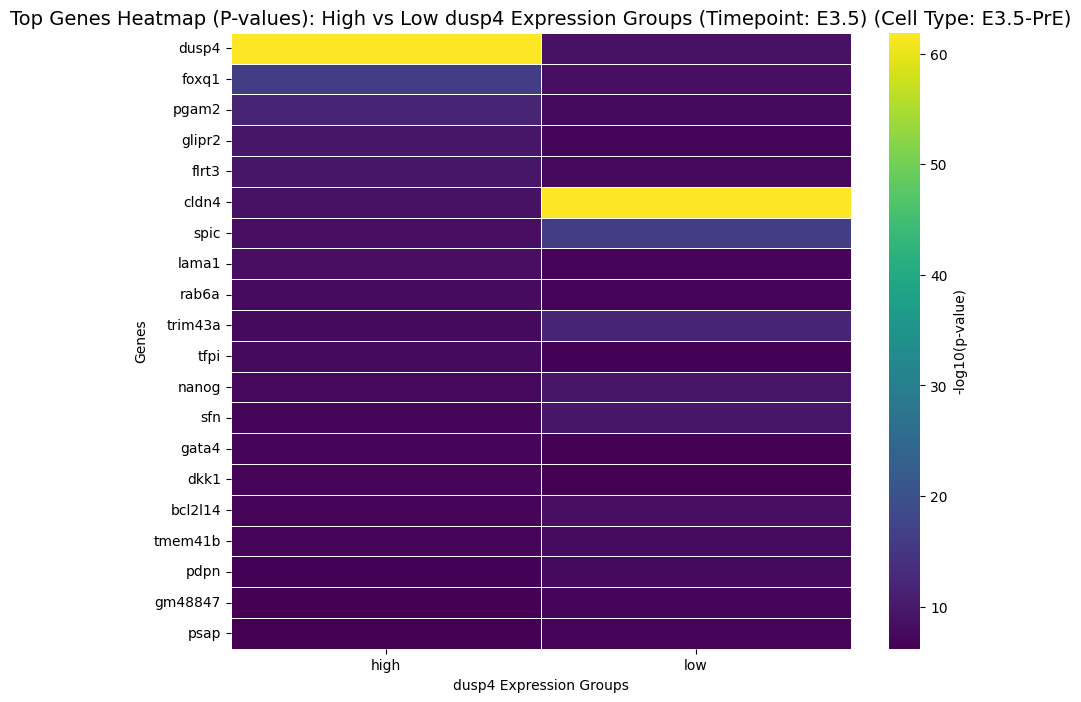

Filtered data shape: (108, 34346)
Top genes: ['sec62', 'dusp4', 'tjp2', 'gm10243', 'gm13341', 'trmt6', 'gm28439', 'zfp993', 'gm28661', 'gm11425', 'rbbp4', 'rrbp1', 'gm4294', 'gm6745', 'dstn', 'dnmt3b', 'utp11', 'nol8', 'tpt1-ps5', 'gm29216']


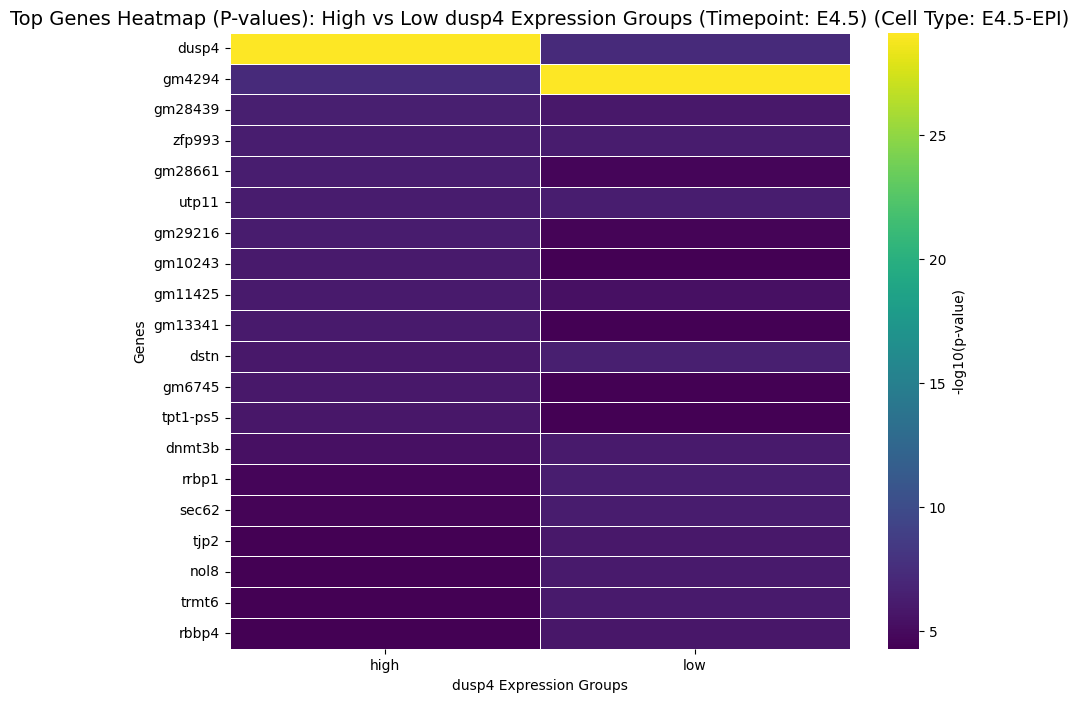

Filtered data shape: (207, 34346)
Top genes: ['dusp4', 'tlk2', '2010110k18rik', 'phyh', 'gm17018', 'pfdn2', 'gm19326', 'utf1', 'gm17802', 'gm49138', 'cd81', 'fam25c', 'ldha-ps2', 'gm9712', 'hspe1-ps2', 'gm11954', 'gm14438', 'rbmxl1', 'gm2926', 'eif1ax']


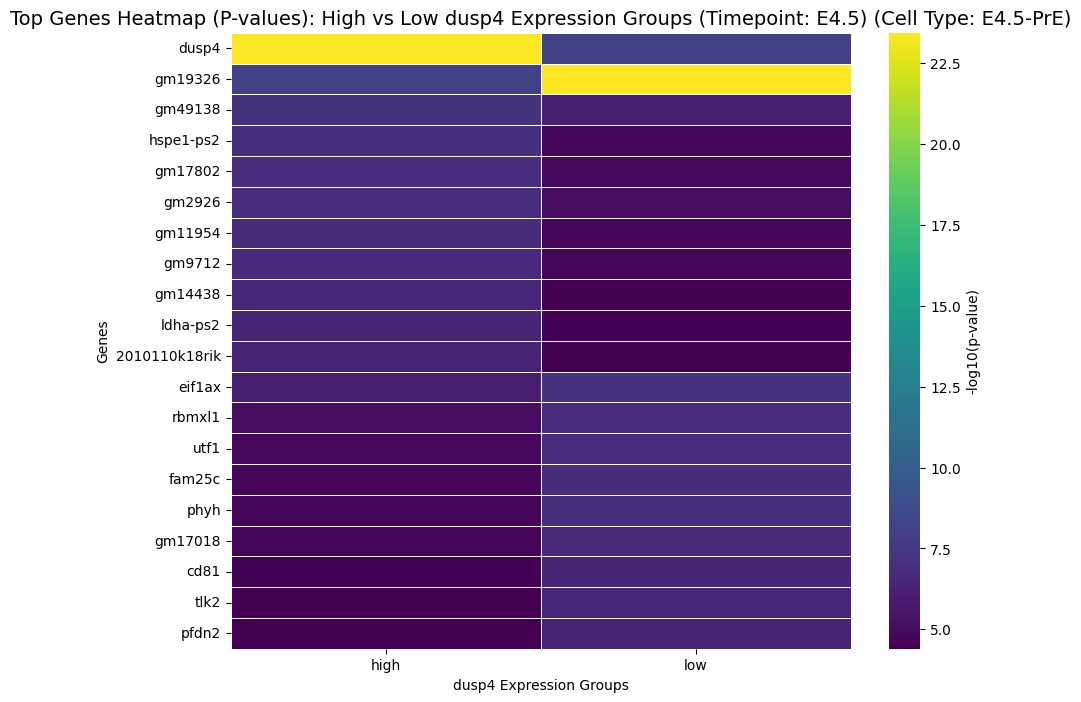

In [10]:
#HEATMAPS

def analyze_gene_correlation_with_pvalues(adata, target_gene, timepoint_filter=None, cell_type_filter=None, save_prefix="Gene"):
    """
    Perform analysis to identify and visualize genes correlated to high/low target gene expression,
    with optional filtering by timepoint and/or cell type, showing p-values in the heatmap.

    Parameters:
        adata: AnnData object
        target_gene: str, the gene to analyze (e.g., "dusp4")
        timepoint_filter: str, filter by UnifiedTimePoint (e.g., "E4.5")
        cell_type_filter: str, filter by cell type (e.g., "Zygote")
        save_prefix: str, prefix for saving files
    """
    # Step 1: Filter the AnnData object by timepoint and/or cell type
    adata_filtered = adata.copy()
    if timepoint_filter:
        adata_filtered = adata_filtered[adata_filtered.obs["UnifiedTimePoint"] == timepoint_filter].copy()
    if cell_type_filter:
        adata_filtered = adata_filtered[adata_filtered.obs["ct"] == cell_type_filter].copy()

    print(f"Filtered data shape: {adata_filtered.shape}")

    # Ensure there are enough cells for analysis
    if adata_filtered.n_obs == 0:
        print("No cells match the given filters. Skipping.")
        return

    # Step 2: Extract target gene expression and classify cells into "low" and "high" groups
    target_gene_data = adata_filtered[:, target_gene].X.toarray().flatten()  # Ensure dense matrix
    threshold = np.median(target_gene_data[target_gene_data > 0])  # Median of non-zero values
    adata_filtered.obs[f"{target_gene}_group"] = np.where(
        target_gene_data > threshold, "high", "low"
    )

    # Step 3: Perform differential gene expression analysis
    sc.tl.rank_genes_groups(
        adata_filtered, 
        groupby=f"{target_gene}_group", 
        method="t-test",  # Use t-test or Wilcoxon
        n_genes=adata_filtered.shape[1]  # Analyze all genes
    )

    # Step 4: Extract p-values for top genes correlated with high/low target gene expression
    top_genes_high = adata_filtered.uns["rank_genes_groups"]["names"]["high"][:10]
    top_genes_low = adata_filtered.uns["rank_genes_groups"]["names"]["low"][:10]
    top_genes = list(set(top_genes_high) | set(top_genes_low))  # Combine and deduplicate
    print(f"Top genes: {top_genes}")

    # Check if top genes are found
    if not top_genes:
        print("No top genes identified for the heatmap. Skipping.")
        return

    # Step 5: Extract p-values for these genes
    pvals = pd.DataFrame(
        {group: adata_filtered.uns["rank_genes_groups"]["pvals"][group] for group in ["high", "low"]},
        index=adata_filtered.uns["rank_genes_groups"]["names"]["high"]
    )
    pvals = pvals.loc[top_genes]  # Filter to top genes

    # Step 6: Sort genes by "high" group p-value (ascending)
    pvals_sorted = pvals.sort_values(by="high", ascending=True)

    # Step 7: Generate the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        -np.log10(pvals_sorted),  # Use -log10(p-value) for visualization
        cmap="viridis",
        linewidths=0.5,
        cbar_kws={"label": "-log10(p-value)"}
    )
    title = f"Top Genes Heatmap (P-values): High vs Low {target_gene} Expression Groups"
    if timepoint_filter:
        title += f" (Timepoint: {timepoint_filter})"
    if cell_type_filter:
        title += f" (Cell Type: {cell_type_filter})"
    plt.title(title, fontsize=14)
    plt.xlabel(f"{target_gene} Expression Groups")
    plt.ylabel("Genes")
    os.makedirs("./figures", exist_ok=True)  # Ensure the output directory exists
    plt.savefig(f"./figures/{save_prefix}_{target_gene}_top_genes_heatmap_pvalues.png", dpi=300, bbox_inches="tight")
    plt.show()


# Ensure "UnifiedTimePoint" is defined
adata.obs["UnifiedTimePoint"] = adata.obs["timepoint"].str.split(":").str[0]

# Example usage for various genes and filters
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E3.25", save_prefix="Brickman_E3_25_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E3.5", save_prefix="Brickman_E3_5_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E4.5", save_prefix="Brickman_E4_5_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E3.25",cell_type_filter="E3.25-ICM", save_prefix="Brickman_E3_25_ICM_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E3.5", cell_type_filter="E3.5-ICM", save_prefix="Brickman_E3_5_ICM_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E3.5", cell_type_filter="E3.5-EPI", save_prefix="Brickman_E3_5_EPI_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E3.5", cell_type_filter="E3.5-PrE", save_prefix="Brickman_E3_5_PrE_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E4.5", cell_type_filter="E4.5-EPI", save_prefix="Brickman_E4_5_EPI_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="ctnnb1", timepoint_filter="E4.5", cell_type_filter="E4.5-PrE", save_prefix="Brickman_E4_5_PrE_Ctnnb1_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E3.25", save_prefix="Brickman_E3_25_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E3.5", save_prefix="Brickman_E3_5_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E4.5", save_prefix="Brickman_E4_5_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E3.25", cell_type_filter="E3.25-ICM", save_prefix="Brickman_E3_25_ICM_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E3.5", cell_type_filter="E3.5-ICM", save_prefix="Brickman_E3_5_ICM_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E3.5", cell_type_filter="E3.5-EPI", save_prefix="Brickman_E3_5_EPI_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E3.5", cell_type_filter="E3.5-PrE", save_prefix="Brickman_E3_5_PrE_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E4.5", cell_type_filter="E4.5-EPI", save_prefix="Brickman_E4_5_EPI_Dusp4_pvalue")
analyze_gene_correlation_with_pvalues(adata, target_gene="dusp4", timepoint_filter="E4.5", cell_type_filter="E4.5-PrE", save_prefix="Brickman_E4_5_PrE_Dusp4_pvalue")

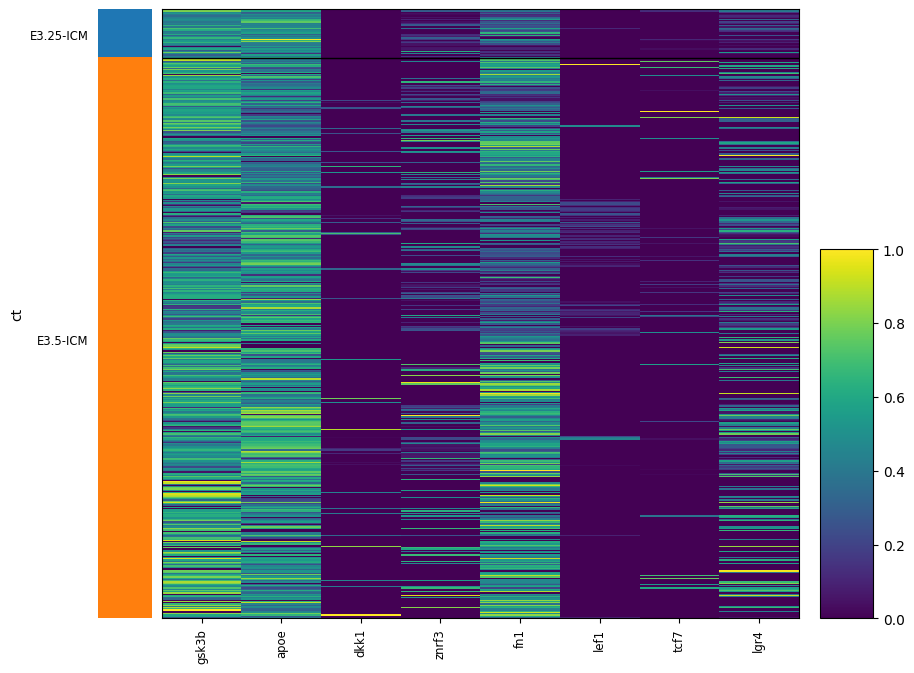

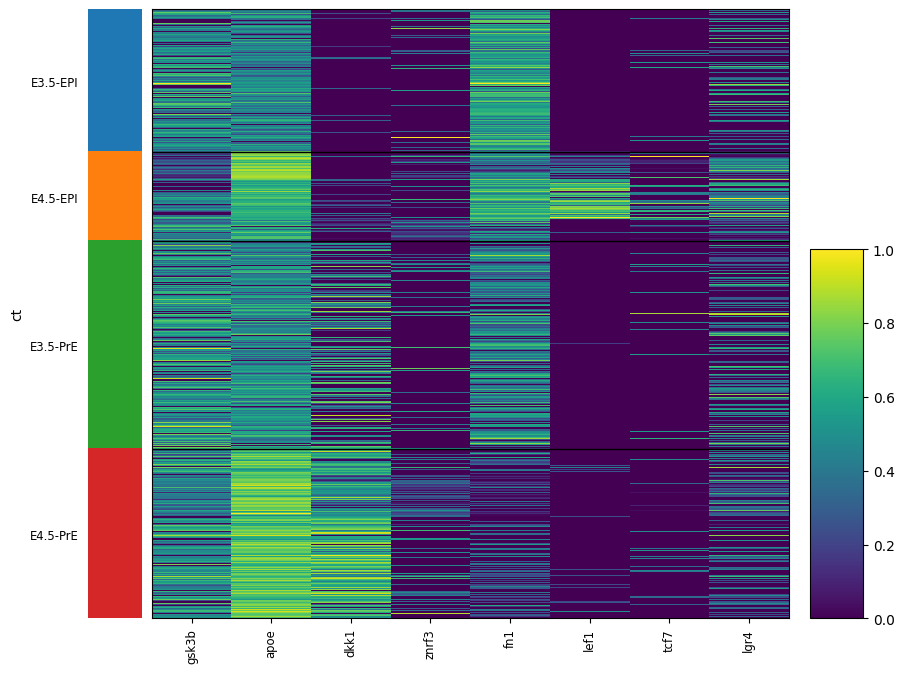

In [4]:

def generate_heatmap(
    adata, 
    timepoint_celltype_groups, 
    genes, 
    colors, 
    output_filename, 
    figsize=(10, 8),
    cmap="viridis",
    standard_scale="var"
):
    """
    Genera un heatmap para los datos de AnnData filtrados por tiempo y tipos celulares específicos.
    
    Parameters:
        adata (AnnData): Objeto AnnData con los datos.
        timepoint_celltype_groups (list): Lista de combinaciones de tiempo y tipos celulares, e.g., ["E3.25-ICM", "E3.5-ICM"].
        genes (list): Lista de genes para incluir en el heatmap.
        colors (dict): Diccionario de colores personalizados para cada tipo celular.
        output_filename (str): Ruta para guardar la figura.
        figsize (tuple): Tamaño de la figura (ancho, alto).
        cmap (str): Mapa de colores a usar para el heatmap.
        standard_scale (str): Escalado estándar ("var" o "obs").
    """
    # Filtrar el AnnData según las combinaciones proporcionadas
    adata_filtered = adata[adata.obs["ct"].isin(timepoint_celltype_groups)].copy()
    
    # Asegurar que los tipos celulares tengan el orden deseado
    adata_filtered.obs["ct"] = (
        adata_filtered.obs["ct"]
        .astype("category")
        .cat.reorder_categories(timepoint_celltype_groups, ordered=True)
    )
    
    # Asignar colores personalizados
    adata_filtered.uns["CellType_colors"] = [
        colors[ct] for ct in adata_filtered.obs["ct"].cat.categories
    ]
    
    # Crear el heatmap
    sc.pl.heatmap(
        adata_filtered,
        var_names=genes,             # Genes relevantes
        groupby="ct",                # Agrupar por tipo celular
        dendrogram=False,            # No incluir dendrograma para respetar el orden
        cmap=cmap,                   # Colormap personalizado
        use_raw=True,                # Usar datos sin procesar
        standard_scale=standard_scale, # Escalado estándar
        show=False                   # No mostrar inmediatamente para ajustar tamaño
    )
    
    # Ajustar tamaño y guardar la figura
    plt.gcf().set_size_inches(*figsize)
    plt.savefig(output_filename, dpi=300, bbox_inches="tight")
    plt.show()

# Definir genes y colores
genes = ["gsk3b", "apoe", "dkk1", "znrf3", "fn1", "lef1", "tcf7", "lgr4"]

celltype_colors = {
    "E3.25-ICM": "#117733",
    "E3.5-ICM": "#44AA99",
    "E3.5-EPI": "#88CCEE",
    "E4.5-EPI": "#CC6677",
    "E3.5-PrE": "#DDCC77",
    "E4.5-PrE": "#AA4499",
}

# Generar figuras para los grupos específicos
generate_heatmap(
    adata=adata,
    timepoint_celltype_groups=["E3.25-ICM", "E3.5-ICM"],
    genes=genes,
    colors=celltype_colors,
    output_filename="./figures/heatmap_E3.25_3.5_ICM.png"
)

generate_heatmap(
    adata=adata,
    timepoint_celltype_groups=["E3.5-EPI", "E4.5-EPI", "E3.5-PrE", "E4.5-PrE"],
    genes=genes,
    colors=celltype_colors,
    output_filename="./figures/heatmap_EPI_PrE.png"
)